In [60]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/四下/pattern_recognition/HW/HW5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/四下/pattern_recognition/HW/HW5


In [24]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.transforms import ToPILImage

'''Train CIFAR10 with PyTorch.'''
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from utils import progress_bar

from sklearn.metrics import accuracy_score

In [69]:
print(torch.__version__)

1.11.0+cu113


In [25]:
!pip install -q pycodestyle
!pip install -q --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Load data

In [27]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# **************************************************** #
# It's a multi-class classification problem

class_index = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
               'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
print(np.unique(y_train))

# **************************************************** #
# Data preprocess

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# **************************************************** #
# flatten the labels
num_classes = 10
train_labels = y_train.flatten()
test_labels = y_test.flatten()
pep8(_ih)

50000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]



## My Data Preprocess

In [28]:
# **************************************************** #
# transformation :
# np --> tensor --> PIL --> random crop/flip
#                       --> normalized tensor
# **************************************************** #
class ciphar10_calss:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index: int):
        return (self.data[index])

    def __len__(self):
        return len(self.data)


# **************************************************** #
def augmentation_on_training_data(x_train):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    _x_train_trans = []
    for i, img in enumerate(x_train):
        new_img = transform_train(img)
        _x_train_trans.append((new_img, train_labels[i]))

    trainloader = torch.utils.data.DataLoader(
        ciphar10_calss(_x_train_trans),
        batch_size=128,
        shuffle=True,
        num_workers=2)

    return trainloader


# **************************************************** #
def normalize_testing_data(x_test, without_label=False):
    transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465),
                           (0.2023, 0.1994, 0.2010)),
    ])

    _x_test_trans = []
    for i, img in enumerate(x_test):
        new_img = transform_test(img)
        # without_label mode is used in the final prediction
        if(without_label):
            _x_test_trans.append(new_img)
        # with_label mode is used as a preview after training
        else:
            _x_test_trans.append((new_img, test_labels[i]))

    testloader = torch.utils.data.DataLoader(
        ciphar10_calss(_x_test_trans),
        batch_size=100,
        shuffle=False,
        num_workers=2)

    return testloader


# **************************************************** #
pep8(_ih)

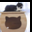

In [ ]:
# PILtransform = transforms.ToPILImage()
# (tensor, target) = _x_train_trans[2]
# img = PILtransform(tensor)
# img

## ResNet18
* Reference1 : https://github.com/kuangliu/pytorch-cifar
* Reference 2 : https://www.796t.com/content/1547627798.html
  * <img src='https://i.imgur.com/2wW9YKB.png' width=400>

In [29]:
# **************************************************** #
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# **************************************************** #
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# **************************************************** #
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


pep8(_ih)

## Initialize model

In [30]:
# **************************************************** #
# 1. init_model()
# 2. resume_model(): resume model from ckpt_{epoch}.pth
# 3. update_opt(mylr):
#     - initialize loss critera,
#     - update learning rate of optimizer
# **************************************************** #
def init_model():
    net = ResNet18()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    return net


# **************************************************** #
def resume_model(file_root, last_epch):
    net = init_model()
    start_epoch = 0

    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir(file_root)
    checkpoint = torch.load(f'{file_root}/ckpt_{last_epch}.pth')
    net.load_state_dict(checkpoint['net'])
    acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(f'acc={acc}')
    return net, start_epoch


# **************************************************** #
def update_opt(net, mylr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=mylr,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max=200)
    return criterion, optimizer, scheduler


pep8(_ih)

In [31]:
# **************************************************** #
# training
# **************************************************** #
def train(epoch, file_root):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), acc, correct, total))

    # Save checkpoint per 5 epoch
    if (epoch % 5 == 0):
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': (100. * correct / total),
            'epoch': epoch,
        }
        if not os.path.isdir(file_root):
            os.mkdir(file_root)
        torch.save(state, f'{file_root}/ckpt_{epoch}.pth')

    # return avg_loss to check whether the model is converged
    return train_loss / len(trainloader)


pep8(_ih)

In [32]:
# **************************************************** #
# testing
# **************************************************** #
def test():
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Testing Accuracy : {100. * correct / total}')


pep8(_ih)

## Main function : Start running

### 1st step

In [ ]:
# **************************************************** #
# configuring parameters
# **************************************************** #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mylr = 0.1
start_epoch = 0
last_epch = 0

# create batch data
trainloader = augmentation_on_training_data(x_train)
testloader = normalize_testing_data(x_test)

# initialize model
net = init_model()
criterion, optimizer, scheduler = update_opt(net, mylr)

pep8(_ih)

In [ ]:
for epoch in range(start_epoch, 140):
    train(epoch, 'ResNet18')
    scheduler.step()

test()
pep8(_ih)


Epoch: 0
 [=============================>]  Step: 560ms | Tot: 41s853ms | Loss: 1.942 | Acc: 30.112% (15056/50000) 391/391 
Saving..

Epoch: 1
 [=============================>]  Step: 77ms | Tot: 41s728ms | Loss: 1.440 | Acc: 47.164% (23582/50000) 391/391 

Epoch: 2
 [=============================>]  Step: 74ms | Tot: 42s805ms | Loss: 1.163 | Acc: 58.188% (29094/50000) 391/391 

Epoch: 3
 [=============================>]  Step: 74ms | Tot: 43s5ms | Loss: 0.959 | Acc: 66.198% (33099/50000) 391/391 

Epoch: 4
 [=============================>]  Step: 79ms | Tot: 42s783ms | Loss: 0.773 | Acc: 72.824% (36412/50000) 391/391 

Epoch: 5
 [=============================>]  Step: 75ms | Tot: 42s486ms | Loss: 0.648 | Acc: 77.214% (38607/50000) 391/391 
Saving..

Epoch: 6
 [=============================>]  Step: 75ms | Tot: 42s191ms | Loss: 0.557 | Acc: 80.562% (40281/50000) 391/3

### 2nd step

In [ ]:
# **************************************************** #
# configure the parameters
# **************************************************** #
mylr = 0.01
last_epoch = 135
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use a new augmented training data (shuffle=True)
trainloader = augmentation_on_training_data(x_train)

# resume model
net,  start_epoch = resume_model('ResNet18', last_epoch)

# setup loss criterion & update learning rate for optimization step
criterion, optimizer, scheduler = update_opt(net, mylr)

==> Resuming from checkpoint..
acc=100.0


In [ ]:
converge = 0
last_train_loss = 1.0
start_epoch = last_epoch

for epoch in range(start_epoch, start_epoch + 20):
    # train the model and get the returned loss
    train_loss = round(train(epoch, 'ResNet18/001'), 3)
    scheduler.step()

    # check whether convergence occurs
    if(train_loss <= 1e-3):
        converge += 1
    else:
        converge = 0
    
    # record the converged epoch
    if (converge >= 5):
        last_epoch = epoch // 5 * 5
        break

test()


Epoch: 135
 [=============================>]  Step: 79ms | Tot: 42s444ms | Loss: 0.355 | Acc: 88.276% (44138/50000) 391/391 
Saving..

Epoch: 136
 [=============================>]  Step: 78ms | Tot: 42s183ms | Loss: 0.139 | Acc: 95.492% (47746/50000) 391/391 

Epoch: 137
 [=============================>]  Step: 72ms | Tot: 42s166ms | Loss: 0.050 | Acc: 98.618% (49309/50000) 391/391 

Epoch: 138
 [=============================>]  Step: 76ms | Tot: 41s928ms | Loss: 0.024 | Acc: 99.376% (49688/50000) 391/391 

Epoch: 139
 [=============================>]  Step: 75ms | Tot: 42s37ms | Loss: 0.014 | Acc: 99.696% (49848/50000) 391/391 

Epoch: 140
 [=============================>]  Step: 71ms | Tot: 42s231ms | Loss: 0.006 | Acc: 99.924% (49962/50000) 391/391 
Saving..

Epoch: 141
 [=============================>]  Step: 73ms | Tot: 41s947ms | Loss: 0.002 | Acc: 99.994% (49997/50000)

### 3rd step

In [ ]:
# **************************************************** #
# configuring parameters
# **************************************************** #
mylr = 0.001
last_epoch = 145
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Use a new augmented training data (shuffle=True)
trainloader = augmentation_on_training_data(x_train)

# resume model
net,  start_epoch = resume_model('ResNet18/001', last_epoch)

# setup loss criterion & update learning rate for optimizer
criterion, optimizer, scheduler = update_opt(net, mylr)
pep8(_ih)

==> Resuming from checkpoint..
acc=100.0



In [ ]:
converge = 0
start_epoch = last_epoch

for epoch in range(start_epoch, start_epoch + 20):
    train_loss = round(train(epoch, 'ResNet18/0001'), 3)
    scheduler.step()

    # check convergence
    if(train_loss <= 1e-3):
        converge += 1
    else:
        converge = 0

    # stopping rule
    if (converge >= 5):
        last_epoch = epoch // 5 * 5
        break

test()
pep8(_ih)


Epoch: 145
 [=============================>]  Step: 578ms | Tot: 42s51ms | Loss: 0.193 | Acc: 93.808% (46904/50000) 391/391 
Saving..

Epoch: 146
 [=============================>]  Step: 76ms | Tot: 42s422ms | Loss: 0.062 | Acc: 98.394% (49197/50000) 391/391 

Epoch: 147
 [=============================>]  Step: 83ms | Tot: 42s314ms | Loss: 0.025 | Acc: 99.648% (49824/50000) 391/391 

Epoch: 148
 [=============================>]  Step: 78ms | Tot: 42s140ms | Loss: 0.013 | Acc: 99.920% (49960/50000) 391/391 

Epoch: 149
 [=============================>]  Step: 74ms | Tot: 42s308ms | Loss: 0.009 | Acc: 99.984% (49992/50000) 391/391 

Epoch: 150
 [=============================>]  Step: 79ms | Tot: 42s286ms | Loss: 0.007 | Acc: 99.986% (49993/50000) 391/391 
Saving..

Epoch: 151
 [=============================>]  Step: 82ms | Tot: 42s131ms | Loss: 0.006 | Acc: 99.996% (49998/50000)

## Loading Model

In [33]:
class Loaded_model():
    def __init__(self, file_path):
        # setup model without GPU
        net = ResNet18()
        net = torch.nn.DataParallel(net)
        self.device = 'cpu'
        self.model = net.to(self.device)

        # load model
        checkpoint = torch.load(file_path, map_location=torch.device('cpu'))
        net.load_state_dict(checkpoint['net'])

        self.model = net
        self.x_test = []

    def predict(self, test_data):
        self.model.eval()
        testloader = normalize_testing_data(x_test, without_label=True)
        prediction = np.array([])

        with torch.no_grad():
            for batch_idx, inputs in enumerate(testloader):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_batch = predicted.detach().numpy()
                prediction = np.concatenate((prediction, predicted_batch))

                # progress bar
                if (batch_idx % 10 == 0):
                    print(f'predicting...{10 + batch_idx}%')
        return prediction


pep8(_ih)

## DO NOT MODIFY CODE BELOW!
**Please screen shot your results and post it on your report**

* Note : Before executing the following code, you should
1.  <font color='red'> switch back to cpu ! ! >< </font>
2. Run Loading Model block above

In [63]:
your_model = Loaded_model('ResNet18/0001/ckpt_160.pth')

In [64]:
y_pred = your_model.predict(x_test)

predicting...10%
predicting...20%
predicting...30%
predicting...40%
predicting...50%
predicting...60%
predicting...70%
predicting...80%
predicting...90%
predicting...100%


In [65]:
assert y_pred.shape == (10000,)

In [66]:
y_test = np.load("y_test.npy")
print("Accuracy of my model on test set: ", accuracy_score(y_test, y_pred))

Accuracy of my model on test set:  0.9212
